# MODEL VS OBSERVATIONS AND CROSS-MOORING ANALYSIS 

In this notebook, I will load in observational CTD data from the Greenland Ecosystem Monitoring (GEM) database and create comparisons with my model output. 
This will allow for model fidelity checks. 

Additionally, I will create a timeseries of vertical velocity at each mooring to compare vertical transport spatially and temporally within the fjord. 

I will also load in nutrient and productivity data to analyze the mooring locations productivity. 

This notebook strives to answer science questions 1, 3, and 4. 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
from eccoseas.downscale import vertical
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import csv
from scipy.interpolate import griddata
import pandas as pd
from matplotlib.colors import ListedColormap 
import glob
from datetime import datetime, timedelta

## PART 1: SETTING UP MODEL GRID 

In [2]:
# Define a path to this lesson's folder
lesson_folder = '/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 13'
obs_data_folder = '/Volumes/T7/ms274/data/GEM/nuuk_CTD' 

In [3]:
# define the parameters that will be used in the data file
XC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/XC720_540.bin', '>f8').reshape(720, 1)
#print(XC)
YC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/YC720_540.bin', '>f8').reshape(540, 1)
#print(YC)
delX = 3.595/720
delY = 1.078/540
xgOrigin = -52.8
ygOrigin = 63.8
n_rows = 540
n_cols = 720

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 9',
                                 'Greenland_bathymetry.bin'),'>f4').reshape(np.shape(XC))

In [4]:
depth = bathy
delR = np.array([1.00,    1.14,    1.30,    1.49,   1.70,
          1.93,    2.20,    2.50,    2.84,   3.21,
          3.63,    4.10,    4.61,    5.18,   5.79,
          6.47,    7.20,    7.98,    8.83,   9.73,
         10.69,   11.70,   12.76,   13.87,  15.03,
         16.22,   17.45,   18.70,   19.97,  21.27,
         22.56,   23.87,   25.17,   26.46,  27.74,
         29.00,   30.24,   31.45,   32.65,  33.82,
         34.97,   36.09,   37.20,   38.29,  39.37])
hfacC_file = '/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 13/hFacC.data'
hfacC = np.fromfile(hfacC_file, '>f4').reshape(45, 540, 720)
land_mask = (hfacC[0, :, :] == 0)   # True = land/dry, False = ocean

## PART 2: GEM DATA

Here I am loading in the GEM data and plotting some initial temp. plots to see what trends are visible. 

In [5]:
lat_ctd = 64.116667
lon_ctd = -51.883333

ctd_filename = "nuuk_ctd_measurements.txt"
ctd_filepath = os.path.join(obs_data_folder, ctd_filename)

df = pd.read_csv(ctd_filepath, sep="\t")   # tab-delimited
df.head()
df.tail()

,Date (YYYY-MM-DD),Time (HH:MM:SS),Julian Day,Station ID,Latitude (DD North),Longitude (DD West),Pressure (avr. Db),Temperature (C),Salinity,Potential temperature (C),"Density, Sigma-theta (kg m-3)",Fluorescence (app. µg/l),PAR (µmol photons m-2 sec-1),Turbidity (FTU)
76715,2024-12-11,1:32:54 PM,346.5645,GF3,64.116667,-51.883333,324,2.3713,33.0197,2.3535,26.3581,0.0764,0.0551,0.423
76716,2024-12-11,1:32:57 PM,346.5646,GF3,64.116667,-51.883333,325,2.3465,33.0191,2.3288,26.3596,0.0765,0.0550,0.467
76717,2024-12-11,1:33:00 PM,346.5646,GF3,64.116667,-51.883333,326,2.3556,33.0205,2.3378,26.3600,0.0768,0.0552,0.447
76718,2024-12-11,1:33:03 PM,346.5646,GF3,64.116667,-51.883333,327,2.3577,33.0203,2.3398,26.3597,0.0797,0.0551,0.451
76719,2024-12-11,1:33:05 PM,346.5646,GF3,64.116667,-51.883333,328,2.3521,33.0200,2.3342,26.3599,0.0768,0.0554,0.420


In [6]:
# Reading in the ctd data into dates and times:

df["Datetime"] = pd.to_datetime(
    df["Date (YYYY-MM-DD)"] + " " + df["Time (HH:MM:SS)"])

start = "2017-02-22"
end   = "2017-02-23"

mask = (df["Datetime"] >= start) & (df["Datetime"] < end)
df_range = df[mask]

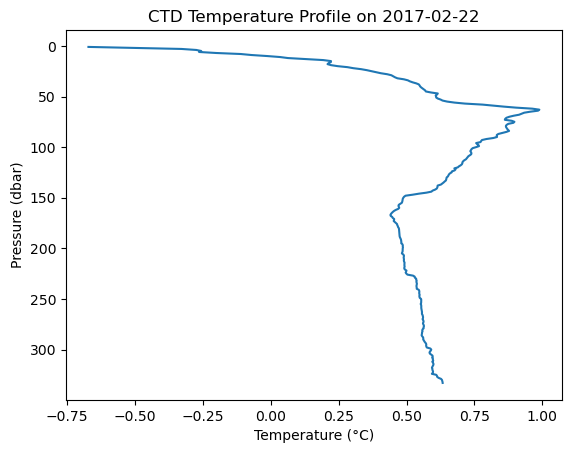

(333, 15)


In [7]:
# plotting an example profile from the ctd data:

plt.plot(df_range["Temperature (C)"], df_range["Pressure (avr. Db)"])
plt.gca().invert_yaxis()

plt.xlabel("Temperature (°C)")
plt.ylabel("Pressure (dbar)")
plt.title(f"CTD Temperature Profile on {start}")
plt.show()

print(df[mask].shape)

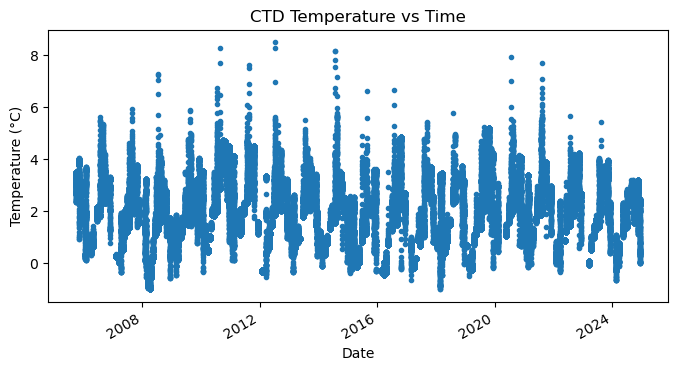

In [8]:
# plotting a timeseries of temperature for the ctd data:

plt.figure(figsize=(8,4))

plt.plot(df["Datetime"], df["Temperature (C)"], marker=".", linestyle="none")

plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("CTD Temperature vs Time")
plt.gcf().autofmt_xdate() 
plt.show()


## PART 3: MOORINGS

Here I will create moorings on my model grid to represent the location of the GEM mooring, and three other "virtual" moorings from my model. 

In [9]:
# use my grid bathymetry
mooring_map = np.copy(bathy)

# find nearest grid point function 
def nearest_point(XC, YC, lon, lat):
    dist2 = (XC - lon)**2 + (YC - lat)**2
    return np.unravel_index(np.argmin(dist2), dist2.shape)

# mooring 1 (GEM)
j1, i1 = nearest_point(XC, YC, -51.883333, 64.116667)
mooring_map[j1, i1] = 1

# mooring 2 (mid-fjord)
j2, i2 = nearest_point(XC, YC, -51.3, 64.6)
mooring_map[j2, i2] = 2

# mooring 3 (near glacier terminus)
j3, i3 = nearest_point(XC, YC, -49.9, 64.41)
mooring_map[j3, i3] = 3


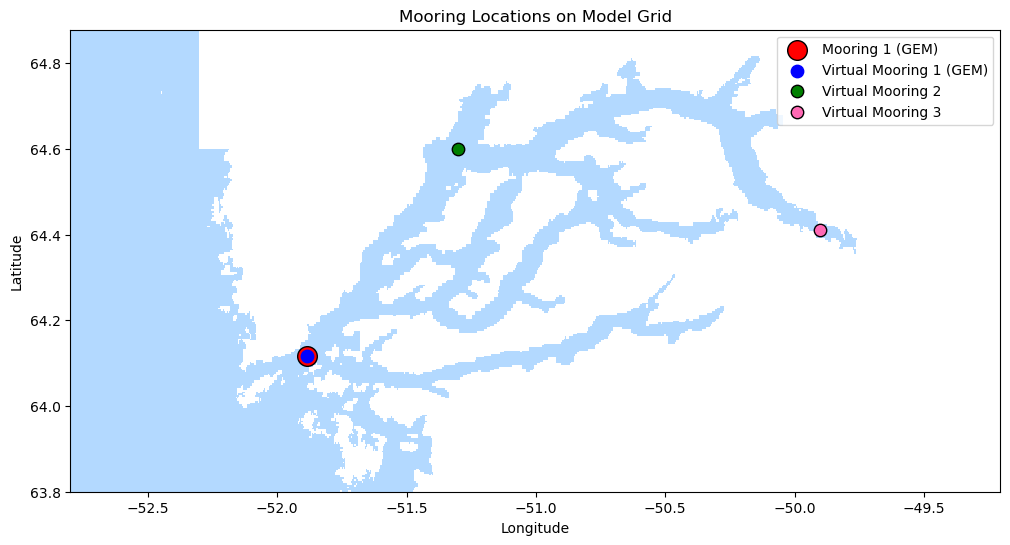

In [10]:
plt.figure(figsize=(12,6))

# mask out the land
hfac_masked = np.ma.masked_where(hfacC[0,:,:] == 0, hfacC[0,:,:])

# just want to plot a solid ocean and land 
ocean_blue = "#b3d9ff"  #light blue color code
land_white = "#ffffff"  
cmap = ListedColormap([ocean_blue, ocean_blue])  # all ocean values = light blue
plt.pcolormesh(XC, YC, hfac_masked, cmap=cmap, vmin=0, vmax=1)

# plot moorings using lon/lat
plt.scatter(lon_ctd, lat_ctd, color='red', s=200, edgecolor='black', label='Mooring 1 (GEM)')
plt.scatter(XC[j1, i1], YC[j1, i1], s=80, c='blue', label='Virtual Mooring 1 (GEM)')
plt.scatter(XC[j2, i2], YC[j2, i2], s=80, c='green', edgecolor='k', label='Virtual Mooring 2')
plt.scatter(XC[j3, i3], YC[j3, i3], s=80, c='hotpink', edgecolor='k', label='Virtual Mooring 3')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mooring Locations on Model Grid")
plt.legend()
plt.show()

In [11]:
model_output = "/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2"

# here I read in the 3D model output and create arrays for theta, salt, and wvel at each mooring location
def read_3d_mooring(j_moor, i_moor):

    theta_list = []  # theta profiles over time
    salt_list  = []  # salinity profiles over time
    wvel_list  = []  # vertical velocity profiles over time
    iter_list  = []  # iteration numbers

    # here I'm finding all 3D T/S snapshot files
    ts_files = sorted(glob.glob(os.path.join(model_output, "TS_3D_snap", "TS_3D_snap.*.data")))

    Nr     = 45   # number of vertical levels
    n_rows = 540  # model grid size (j direction)
    n_cols = 720  # model grid size (i direction)

    for ts_file in ts_files:

        # get the iteration number from the filename
        iter_str  = ts_file.split(".")[-2]
        iteration = int(iter_str)

        # here I load the 3D theta/salt fields
        TS = np.fromfile(ts_file, ">f4").reshape(2, Nr, n_rows, n_cols)
        THETA_3d = TS[0]
        SALT_3d  = TS[1]

        # now I load the matching WVEL file (skipping if it's missing)
        w_file = os.path.join(model_output, "WVEL_3D_snap", f"WVEL_3D_snap.{iter_str}.data")
        if not os.path.isfile(w_file):
            print(f"Skipping {iteration}: WVEL file missing")
            continue

        WVEL_3d = np.fromfile(w_file, ">f4").reshape(Nr, n_rows, n_cols)

        # now I'm extracting the vertical column at the mooring point
        theta_list.append(THETA_3d[:, j_moor, i_moor])
        salt_list.append(SALT_3d[:,  j_moor, i_moor])
        wvel_list.append(WVEL_3d[:,  j_moor, i_moor])
        iter_list.append(iteration)

    # turning the lists into arrays for easier plotting later
    iters    = np.array(iter_list)
    THETA_ts = np.array(theta_list)
    SALT_ts  = np.array(salt_list)
    WVEL_ts  = np.array(wvel_list)

    return iters, THETA_ts, SALT_ts, WVEL_ts


In [12]:
# Mooring 1
iters1, THETA1, SALT1, WVEL1 = read_3d_mooring(j1, i1)

# Mooring 2
iters2, THETA2, SALT2, WVEL2 = read_3d_mooring(j2, i2)

# Mooring 3
iters3, THETA3, SALT3, WVEL3 = read_3d_mooring(j3, i3)


Skipping 60840: WVEL file missing
Skipping 61560: WVEL file missing
Skipping 62280: WVEL file missing
Skipping 63000: WVEL file missing
Skipping 60840: WVEL file missing
Skipping 61560: WVEL file missing
Skipping 62280: WVEL file missing
Skipping 63000: WVEL file missing
Skipping 60840: WVEL file missing
Skipping 61560: WVEL file missing
Skipping 62280: WVEL file missing
Skipping 63000: WVEL file missing


In [13]:
# here I'm converting delR (layer thicknesses) into actual depths
delR = np.array(delR)

# depth of each model layer center
model_depths = np.cumsum(delR) - 0.5 * delR    

#  now i'm finding which model levels are closest to 5 m, 50 m, and 200 m
desired_depths = [5.0, 50.0, 200.0]

# this will store the model layers (delR) that match those depths
model_layers_for_desired_depths = []

for depth in desired_depths:

    # find the index of the model layer whose depth is closest to the desired depth
    closest_layer = np.argmin(np.abs(model_depths - depth))

    model_layers_for_desired_depths.append(closest_layer)

    print('Requested depth:', depth, 'm → model level', closest_layer,
          '(actual depth:', round(model_depths[closest_layer], 1), 'm)')

layer_5m, layer_50m, layer_200m = model_layers_for_desired_depths

Requested depth: 5.0 m → model level 4 (actual depth: 5.8 m)
Requested depth: 50.0 m → model level 16 (actual depth: 52.7 m)
Requested depth: 200.0 m → model level 28 (actual depth: 209.2 m)


In [14]:
# # here i'm converting iteration numbers into model time (in days)

deltaT = 30.0
start_datetime = datetime(2017, 1, 1)

# turning iters into dates so i can plot time series with real dates
time_dates = []
for iteration in iters1:
    model_seconds = iteration * deltaT
    time_dates.append(start_datetime + timedelta(seconds=float(model_seconds)))

time_dates = np.array(time_dates)

print("First date:", time_dates[0])
print("Last date:", time_dates[-1])

First date: 2017-01-23 03:00:00
Last date: 2017-04-08 21:00:00


In [15]:
# grabbing wvel time series at three depths for each mooring

w1_surface = WVEL1[:, layer_5m]
w1_50m     = WVEL1[:, layer_50m]
w1_200m    = WVEL1[:, layer_200m]

w2_surface = WVEL2[:, layer_5m]
w2_50m     = WVEL2[:, layer_50m]
w2_200m    = WVEL2[:, layer_200m]

w3_surface = WVEL3[:, layer_5m]
w3_50m     = WVEL3[:, layer_50m]
w3_200m    = WVEL3[:, layer_200m]


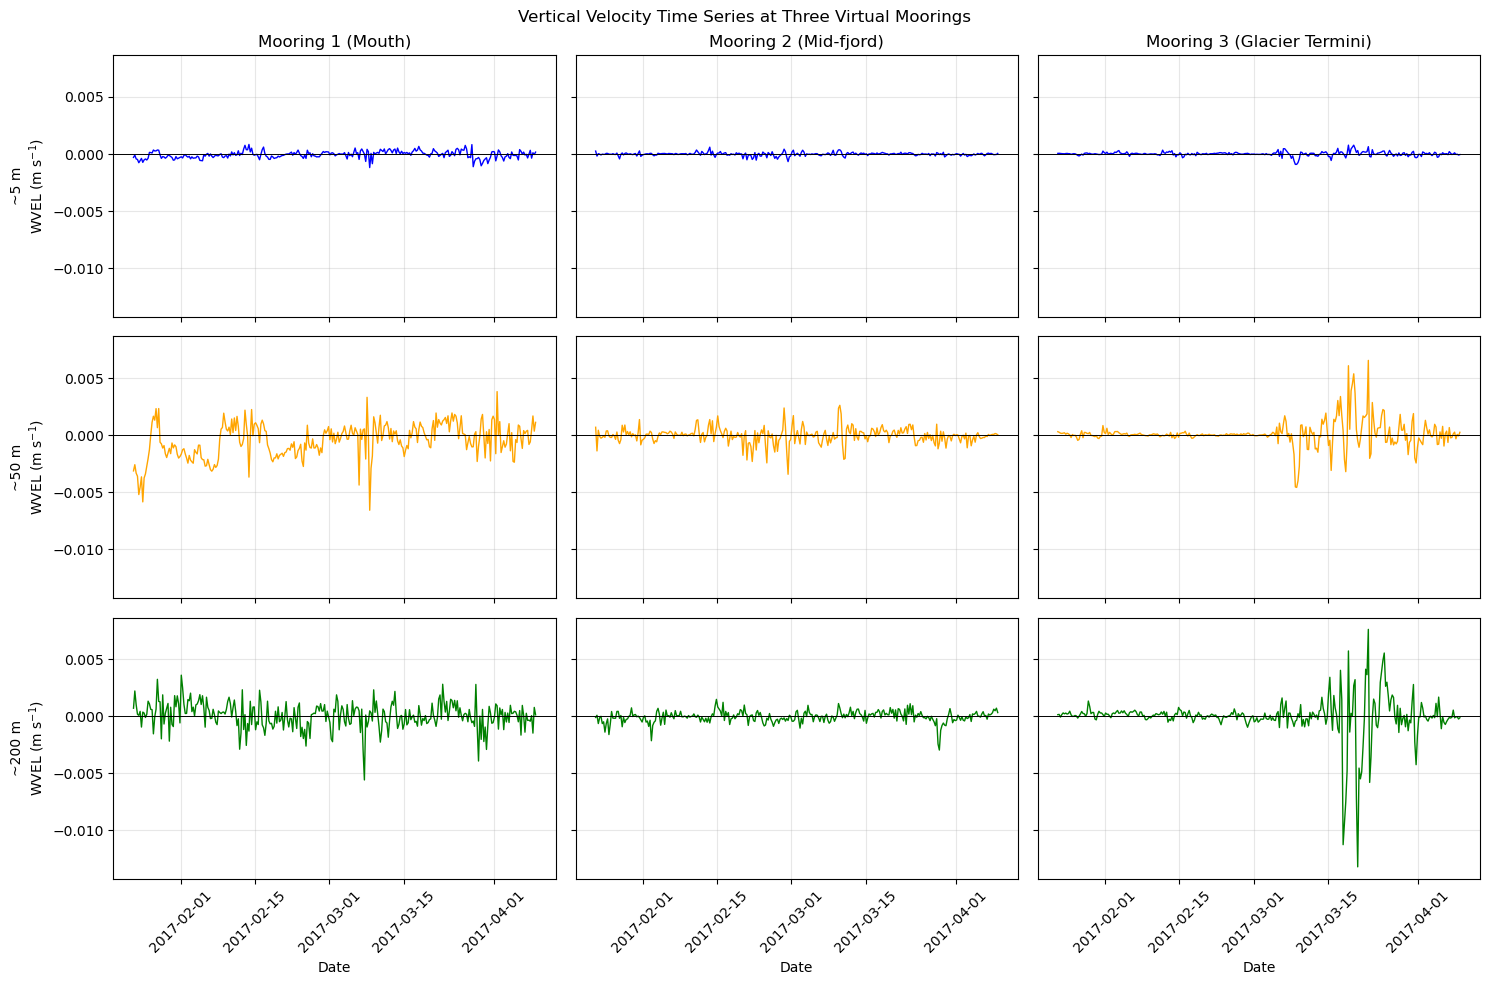

In [16]:
# here i am plotting a timeseries of vertical velocity at three different depths across the three moorings to understand science questions 1 and 2

fig, axs = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)

# these are the labels for plots
mooring_labels = ["Mooring 1 (Mouth)", "Mooring 2 (Mid-fjord)", "Mooring 3 (Glacier Termini)"]
depth_labels   = ["~5 m", "~50 m", "~200 m"]

# here i group each wvel time series by depth so i can plot each row separately
w_depths = [
    [w1_surface, w2_surface, w3_surface],   # row 0: surface (~5 m)
    [w1_50m,     w2_50m,     w3_50m],       # row 1: ~50 m
    [w1_200m,    w2_200m,    w3_200m],]      # row 2: ~200 m

# here i'm using the same date array for each mooring
time_list = [time_dates, time_dates, time_dates]

# now i'm assigning one color per depth row
colors = ["blue", "orange", "green"]

# this is my plotting code
for r in range(3):          # depth row
    for c in range(3):      # mooring column

        ax = axs[r, c]

        ax.plot(time_list[c], w_depths[r][c], color=colors[r], linewidth=1)

        ax.axhline(0, color="k", linewidth=0.7)
        ax.grid(alpha=0.3)

        # left label
        if c == 0:
            ax.set_ylabel(f"{depth_labels[r]}\nWVEL (m s$^{{-1}}$)")

        # top label
        if r == 0:
            ax.set_title(mooring_labels[c])

#  x-axis labels + dates
for c in range(3):
    axs[2, c].set_xlabel("Date")
    axs[2, c].tick_params(axis="x", rotation=45)

plt.suptitle("Vertical Velocity Time Series at Three Virtual Moorings")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### ANALYSIS:

The vertical velocity (WVEL) time series highlight distinct spatial differences in vertical transport across the fjord. Positive WVEL values indicate upwelling, while negative values correspond to downwelling. The largest variability is observed at Mooring 1 near the fjord mouth, suggesting this region acts as a vertical mixing hotspot. This enhanced variability is likely driven by strong ocean-fjord exchange, tidal forcing, and the presence of shallow bathymetry (potentially a sill), which together promote intensified vertical motions compared to the more stratified inner fjord.

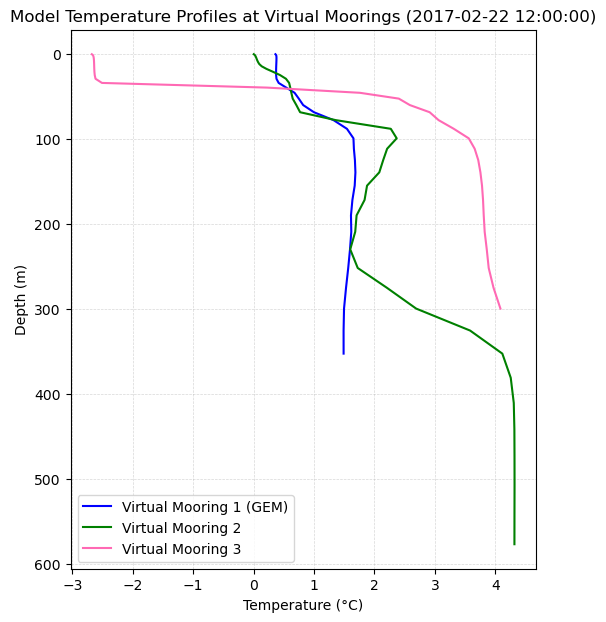

In [18]:
# here im plotting the theta profiles at a given date for each mooring
moorings = [
    ("Virtual Mooring 1 (GEM)", j1, i1, THETA1, "blue"),
    ("Virtual Mooring 2",       j2, i2, THETA2, "green"),
    ("Virtual Mooring 3",       j3, i3, THETA3, "hotpink")]

# date i want to plot (year, month, day, hour)
date = datetime(2017, 2, 22, 12)

# here i find the model time closest to this date
t = np.argmin(np.abs(np.array(time_dates) - date))

delR = np.asarray(delR)
z_centers = np.cumsum(delR) - 0.5 * delR

plt.figure(figsize=(6, 7))

for label, j, i, THETA_ts, color in moorings:

    # temperature profile at this time (1D over depth)
    theta_col = THETA_ts[t, :]

    # wet mask at this mooring
    wet_mask = hfacC[:, j, i] > 0

    theta_wet = theta_col[wet_mask]
    depth_wet = z_centers[wet_mask]

    plt.plot(theta_wet, depth_wet, label=label, color=color)

plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title(f"Model Temperature Profiles at Virtual Moorings ({date})")
plt.grid(linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend()
plt.show()


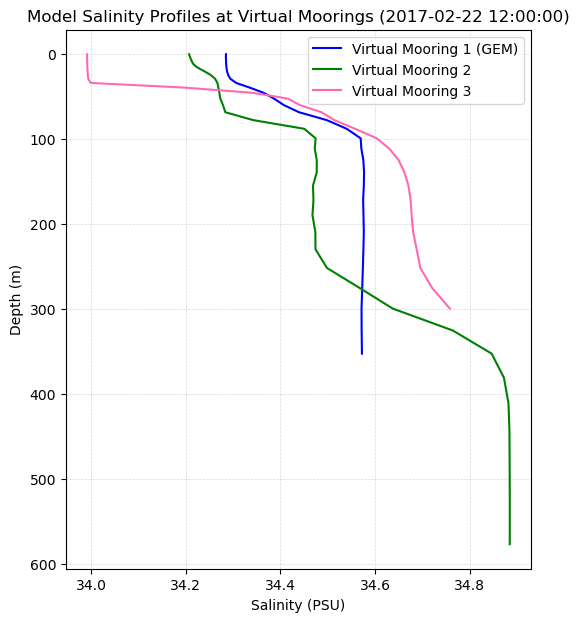

In [19]:
# here im plotting the salt profiles at a given date for each mooring
moorings = [
    ("Virtual Mooring 1 (GEM)", j1, i1, SALT1, "blue"),
    ("Virtual Mooring 2",       j2, i2, SALT2, "green"),
    ("Virtual Mooring 3",       j3, i3, SALT3, "hotpink")]

# date i want to plot (year, month, day, hour)
date = datetime(2017, 2, 22, 12)

# here i find the model time closest to this date
t = np.argmin(np.abs(np.array(time_dates) - date))

delR = np.asarray(delR)
z_centers = np.cumsum(delR) - 0.5 * delR

plt.figure(figsize=(6, 7))

for label, j, i, SALT_ts, color in moorings:

    # temperature profile at this time (1D over depth)
    salt_col = SALT_ts[t, :]

    # wet mask at this mooring
    wet_mask = hfacC[:, j, i] > 0

    salt_wet = salt_col[wet_mask]
    depth_wet = z_centers[wet_mask]

    plt.plot(salt_wet, depth_wet, label=label, color=color)

plt.gca().invert_yaxis()
plt.xlabel("Salinity (PSU)")
plt.ylabel("Depth (m)")
plt.title(f"Model Salinity Profiles at Virtual Moorings ({date})")
plt.grid(linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend()
plt.show()

### ANALYSIS:
The vertical temperature profiles show clear spatial differences in stratification across the fjord. Mooring 3, located near the glacier termini, exhibits the sharpest thermocline, indicating strong stratification driven by cold, fresh glacial meltwater overlying warmer water at depth. This strong stratification is reinforced by sharp salinity gradients, particularly in the mid- and inner fjord, indicating a stable water column and limited background mixing. In contrast, Mooring 1 at the fjord mouth shows weaker stratification and a more diffuse thermocline, consistent with enhanced vertical mixing associated with ocean–fjord exchange. Across all moorings, warmer water persists at depth, reflecting classic fjord dynamics in which relatively warm Atlantic-origin water enters the fjord below cooler surface layers maintained by meltwater and atmospheric forcing.

## PART 4: COMPARING CTD PROFILES TO MODEL PROFILES AT MOORING 1 (GEM)

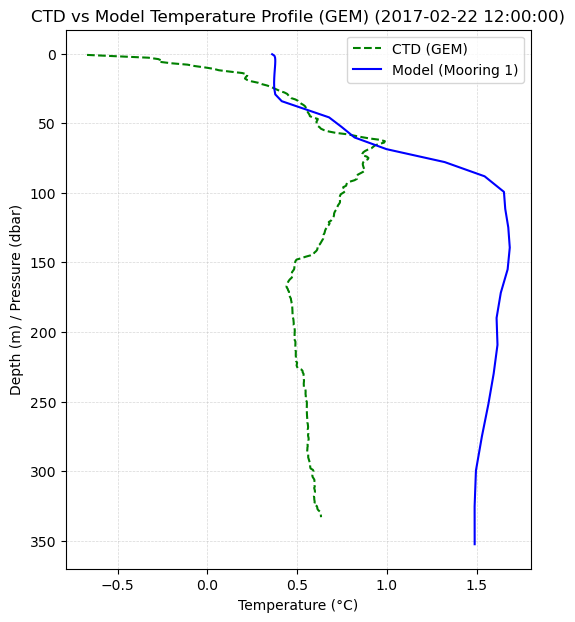

In [20]:
# here i am comparing the ctd (observational data) to the model data at mooring 1 to answer science question 4

# date i want to plot (year, month, day, hour)
date = datetime(2017, 2, 22, 12)

# here i find the model time closest to this date
t = np.argmin(np.abs(np.array(time_dates) - date))

# model depth 
delR = np.asarray(delR, float)
z_centers = np.cumsum(delR) - 0.5 * delR  

# model theta profile at mooring 1 
theta_col = THETA1[t, :]  
wet_mask  = hfacC[:, j1, i1] > 0

theta_wet = theta_col[wet_mask]
depth_wet = z_centers[wet_mask]

plt.figure(figsize=(6, 7))

# ctd theta profile at GEM mooring 
plt.plot(df_range["Temperature (C)"], df_range["Pressure (avr. Db)"], label="CTD (GEM)", linestyle="--", color='green')

# virtual mooring 1 theta profile 
plt.plot(theta_wet, depth_wet, label="Model (Mooring 1)", color="blue")

plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m) / Pressure (dbar)")
plt.title(f"CTD vs Model Temperature Profile (GEM) ({date})")
plt.grid(linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend()
plt.show()

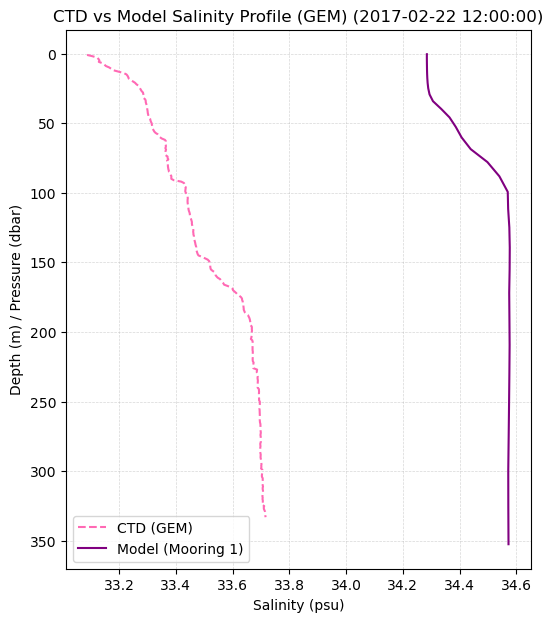

In [22]:
# here i am comparing the ctd (observational data) to the model data at mooring 1 to answer science question 4

# date i want to plot (year, month, day, hour)
date = datetime(2017, 2, 22, 12)

# here i find the model time closest to this date
t = np.argmin(np.abs(np.array(time_dates) - date))

# model depth 
delR = np.asarray(delR, float)
z_centers = np.cumsum(delR) - 0.5 * delR  

# model salt profile at mooring 1 
salt_col = SALT1[t, :]  
wet_mask = hfacC[:, j1, i1] > 0

salt_wet  = salt_col[wet_mask]
depth_wet = z_centers[wet_mask]

plt.figure(figsize=(6, 7))

# ctd salt profile at GEM mooring 
plt.plot(df_range["Salinity"], df_range["Pressure (avr. Db)"], label="CTD (GEM)", linestyle="--", color="hotpink")

# virtual mooring 1 salt profile 
plt.plot(salt_wet, depth_wet, label="Model (Mooring 1)", color="purple")

plt.gca().invert_yaxis()
plt.xlabel("Salinity (psu)")
plt.ylabel("Depth (m) / Pressure (dbar)")
plt.title(f"CTD vs Model Salinity Profile (GEM) ({date})")
plt.grid(linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend()
plt.show()

### ANALYSIS:

Comparing the model and the in situ observational data, it is clear that there are some inconsistencies between the profiles (taken from the same location at the same time). This may be due to model spin up or lack of sea ice and glaciers in the model. Moving forward, running the model for a longer amount of time and adding in these key features may generate a more representative model. 

## PART 5: NUTRIENTS AT MOORINGS

In [23]:
# # here i'm reading in the ptracers for my model output at a mooring location

# # this code block reads in a ton of data and unfortunately causes the kernel to fail
#     # to avoid this, i am just going to read in nitrate in a block below, 
#         # but wanted to include this because it is what i would do if my kernel had the capacity 


# def read_bling_tracers_at_mooring(model_output, j_moor, i_moor):

#     # lists to store profiles over time
#     dic_list = []
#     alk_list = []
#     o2_list  = []
#     no3_list = []
#     po4_list = []
#     fet_list = []
#     don_list = []
#     dop_list = []

#     iter_list = []

#     trac_dir = os.path.join(model_output, "bling", "blingTracDiag")
#     trac_files = sorted(glob.glob(os.path.join(trac_dir, "blingTracDiag.*.data")))

#     Nr = 45
#     ny = 540
#     nx = 720

#     for trac_file in trac_files:

#         # get iteration number from filename
#         iter_str  = trac_file.split(".")[-2]
#         iteration = int(iter_str)

#         # read full BLING tracer file
#         TR = np.fromfile(trac_file, ">f4").reshape(8, Nr, ny, nx)

#         # extract vertical columns at this mooring
#         dic_col = TR[0, :, j_moor, i_moor]
#         alk_col = TR[1, :, j_moor, i_moor]
#         o2_col  = TR[2, :, j_moor, i_moor]
#         no3_col = TR[3, :, j_moor, i_moor]
#         po4_col = TR[4, :, j_moor, i_moor]
#         fet_col = TR[5, :, j_moor, i_moor]
#         don_col = TR[6, :, j_moor, i_moor]
#         dop_col = TR[7, :, j_moor, i_moor]

#         # append to lists
#         dic_list.append(dic_col)
#         alk_list.append(alk_col)
#         o2_list.append(o2_col)
#         no3_list.append(no3_col)
#         po4_list.append(po4_col)
#         fet_list.append(fet_col)
#         don_list.append(don_col)
#         dop_list.append(dop_col)

#         iter_list.append(iteration)

#     # convert to arrays (time, depth)
#     iters = np.array(iter_list)

#     DIC = np.array(dic_list)
#     ALK = np.array(alk_list)
#     O2  = np.array(o2_list)
#     NO3 = np.array(no3_list)
#     PO4 = np.array(po4_list)
#     FeT = np.array(fet_list)
#     DON = np.array(don_list)
#     DOP = np.array(dop_list)

#     return iters, DIC, ALK, O2, NO3, PO4, FeT, DON, DOP


In [37]:
bling_output_file = '/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/blingTracDiag/blingTracDiag.0000147240.data'

bling_output_grid = np.fromfile(bling_output_file, '>f4').reshape(8, 45, 540, 720)

print(bling_output_grid.shape)

(8, 45, 540, 720)


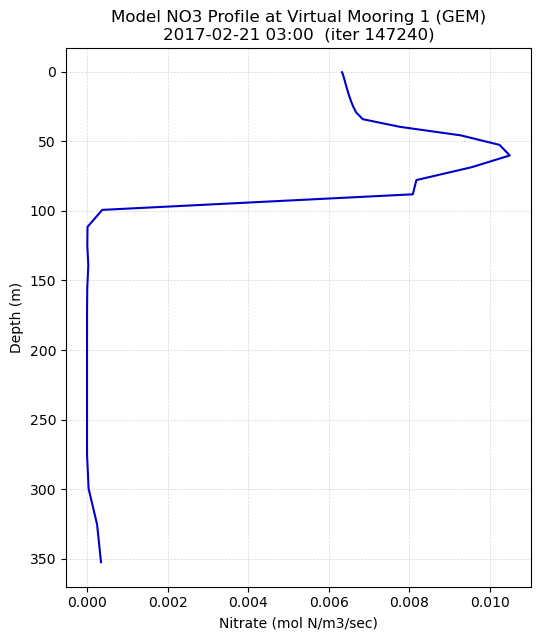

In [50]:
# here i am plotting nitrate at one mooring (GEM) to check the profile was read in correctly 

nitrate_3d = bling_output_grid[3, :, :, :]   # NO3 (TRAC04)

deltaT = 30.0
start_datetime = datetime(2017, 1, 1)

delR = np.asarray(delR, float)
z_centers = np.cumsum(delR) - 0.5 * delR

# date i want to plot (year, month, day, hour)
date = datetime(2017, 2, 22, 12)

# iter to date 
iter_str  = os.path.basename(bling_output_file).split(".")[-2]
iteration = int(iter_str)
file_datetime = start_datetime + timedelta(seconds=int(iteration * deltaT))

# model nitrate profile at mooring 1
no3_profile = nitrate_3d[:, j1, i1]
wet_mask    = hfacC[:, j1, i1] > 0

no3_wet   = no3_profile[wet_mask]
depth_wet = z_centers[wet_mask]

# plotting nitrate profile

plt.figure(figsize=(6, 7))
plt.plot(no3_wet, depth_wet, color="mediumblue")
plt.gca().invert_yaxis()

plt.xlabel("Nitrate (mol N/m3/sec)")
plt.ylabel("Depth (m)")
plt.title(f"Model NO3 Profile at Virtual Mooring 1 (GEM)\n{file_datetime:%Y-%m-%d %H:%M}  (iter {iteration})")
plt.grid(linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()


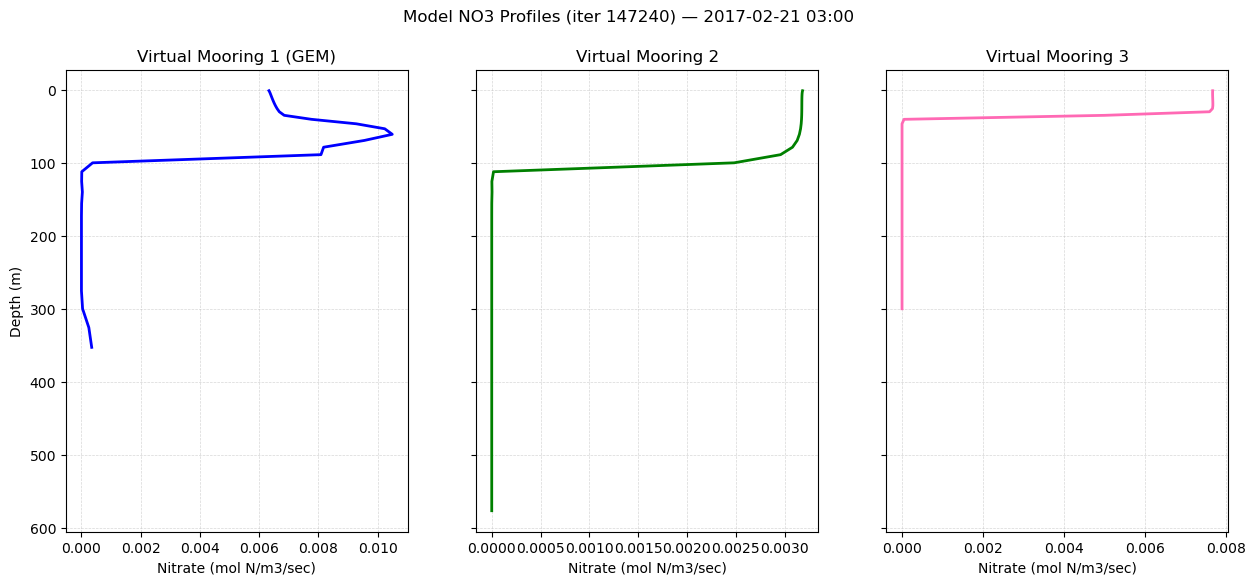

In [52]:
# now comparing nitrate profile at all three moorings 

bling_output_file = "/Volumes/T7/ms274/data/Model_Output/greenland_model_1/run/diags_2/bling/blingTracDiag/blingTracDiag.0000147240.data"

deltaT = 30.0                        
start_datetime = datetime(2017, 1, 1)

# listing the mooring locations (j,i)
moorings = [
    ("Virtual Mooring 1 (GEM)", j1, i1, "blue"),
    ("Virtual Mooring 2",       j2, i2, "green"),
    ("Virtual Mooring 3",       j3, i3, "hotpink")]

# iter to date 
iter_str = os.path.basename(bling_output_file).split(".")[-2]  
iteration = int(iter_str)
model_seconds = int(iteration * deltaT)
date = start_datetime + timedelta(seconds=model_seconds)

# pulling out the nitrate tracer 
bling_output_grid = np.fromfile(bling_output_file, ">f4").reshape(8, 45, 540, 720)
nitrate_3d = bling_output_grid[3, :, :, :]  

delR = np.asarray(delR)
z_centers = np.cumsum(delR) - 0.5 * delR

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for ax, (label, j_moor, i_moor, color) in zip(axes, moorings):

    # nitrate profile at this mooring (over depth)
    no3_profile = nitrate_3d[:, j_moor, i_moor]

    # only plot wet cells at this column
    wet_mask = hfacC[:, j_moor, i_moor] > 0
    no3_wet = no3_profile[wet_mask]
    depth_wet = z_centers[wet_mask]

    ax.plot(no3_wet, depth_wet, color=color, linewidth=2)
    ax.invert_yaxis()
    ax.grid(linestyle="--", linewidth=0.5, alpha=0.5)

    ax.set_title(label)
    ax.set_xlabel("Nitrate (mol N/m3/sec)")

axes[0].set_ylabel("Depth (m)")

fig.suptitle(f"Model NO3 Profiles (iter {iteration}) — {date:%Y-%m-%d %H:%M}")
plt.tight_layout
plt.show()


### ANALYSIS:

The nitrate profiles highlight a strong link between physical structure, mixing, and potential primary productivity in Nuup Kangerlua. Nitrate is depleted near the surface and increases with depth at all moorings, consistent with a strongly stratified fjord where surface nutrients are consumed by biological uptake. Elevated subsurface nitrate and weaker vertical gradients at the fjord mouth suggest enhanced vertical exchange, indicating a potential mixing hotspot that may intermittently resupply nutrients to the euphotic zone, while sharper gradients in the inner fjord imply more limited nutrient supply and stronger stratification.